# Appliying machine learning to Datasport dataset

In this notebook we present:

* [Exploratory Statistics](#Exploratory-statistics)
* [Machine Learning-driven analysis](#ML-driven-analysis) on runners' performances 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from scipy import stats

import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

## Exploratory statistics

### Loading the dataset

In [2]:
full_df = pd.read_pickle('../../full_dataframe_weather.pickle')

print(full_df.shape)
print('\n Number of nulls: \n\n',full_df.isnull().sum())
print('\n Data-type: \n\n',full_df.dtypes)
full_df.head(3)

(1270319, 15)

 Number of nulls: 

 Race                0
Date                0
Distance            0
Name                0
Sex                 0
Year                0
LivingPlace         0
Rank                0
Time                0
Pace                0
Place               0
MinTemp        173925
MaxTemp        173925
Weather        173925
RaceID              0
dtype: int64

 Data-type: 

 Race                    object
Date                    object
Distance               float64
Name                    object
Sex                     object
Year                     int64
LivingPlace             object
Rank                     int64
Time           timedelta64[ns]
Pace           timedelta64[ns]
Place                   object
MinTemp                float64
MaxTemp                float64
Weather                 object
RaceID                  object
dtype: object


,Race,Date,Distance,Name,Sex,Year,LivingPlace,Rank,Time,Pace,Place,MinTemp,MaxTemp,Weather,RaceID
0,"Jungfrau-Marathon, Interlaken",sam. 06.09.2003,42.195,Abächerli Walter,M,1952,Hinwil,47,04:31:56.100000,00:06:26,Interlaken,NaN,NaN,NaN,http://services.datasport.com/2003/lauf/jungfrau
1,"Jungfrau-Marathon, Interlaken",sam. 06.09.2003,42.195,Abbringh Ellen,F,1962,NL-Doorn 3941 EB,91,05:55:09.400000,00:08:25,Interlaken,NaN,NaN,NaN,http://services.datasport.com/2003/lauf/jungfrau
2,"Jungfrau-Marathon, Interlaken",sam. 06.09.2003,42.195,Abegglen Eddy,M,1954,Mürren,424,05:45:21.900000,00:08:11,Interlaken,NaN,NaN,NaN,http://services.datasport.com/2003/lauf/jungfrau


Fixing `Date` feature:

In [3]:
full_df.Date = [pd.to_datetime(my_date.split(' ')[1],format='%d.%m.%Y').date()
                for my_date in full_df.Date]

full_df.Date = full_df.Date.astype('datetime64')

In [4]:
full_df.Date = full_df.Date.astype('datetime64')

TypeError: cannot astype a datetimelike from [datetime64[ns]] to [datetime64]

Fixing `Distance` feature:

In [ ]:
full_df.Distance = full_df.Distance.round()
full_df.Distance.unique()

### Distribution of runners across time
(mind that data are binned by year - each runner might _compete several times_ in the same year)

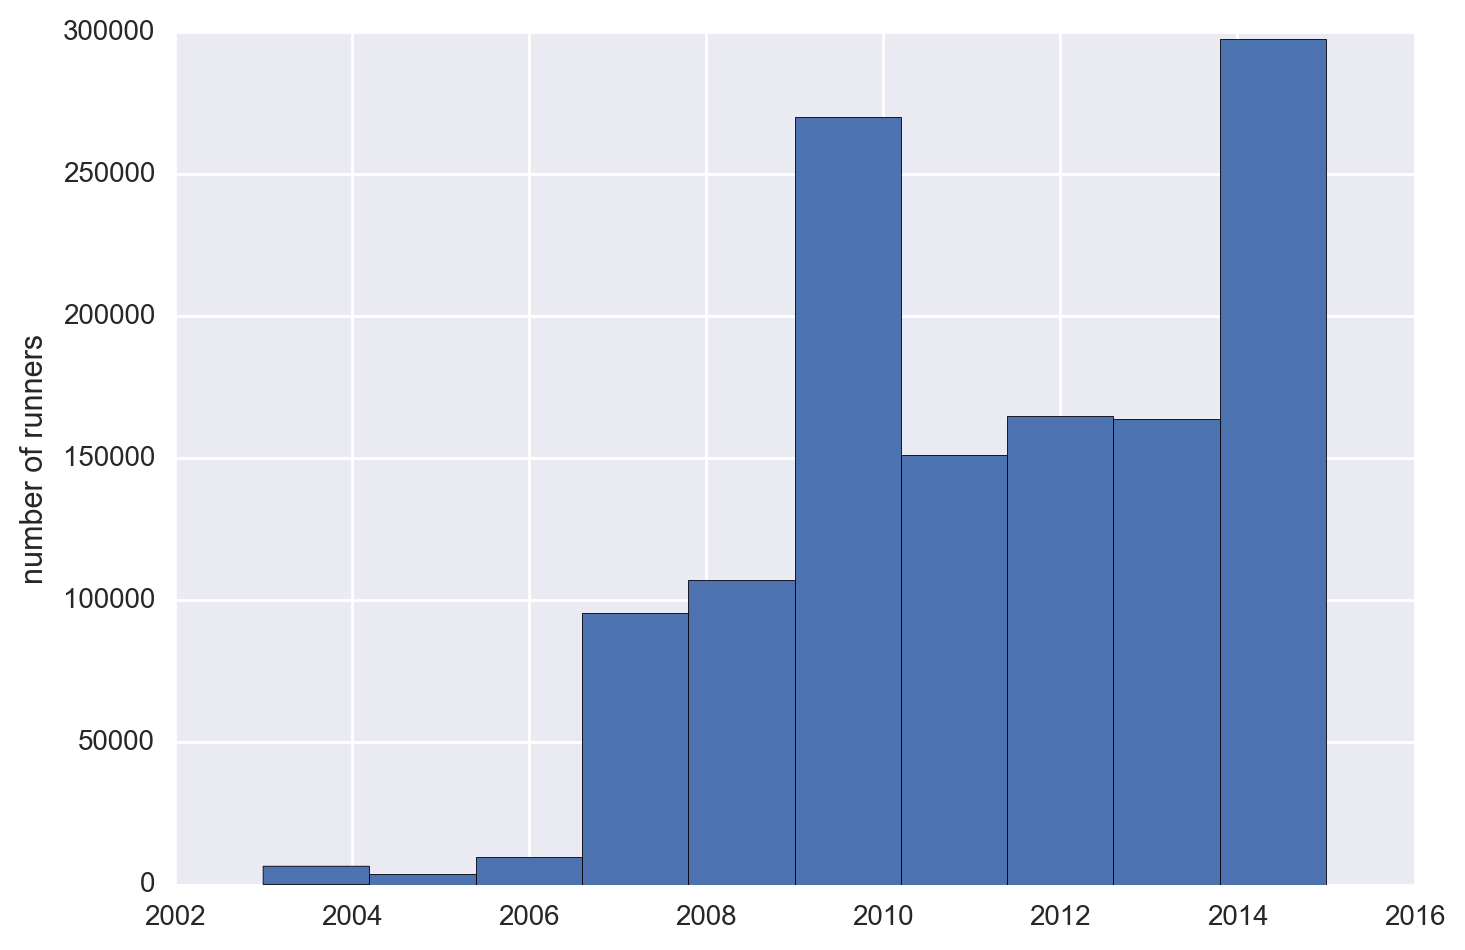

In [68]:
plt.hist(full_df.Date.dt.year)
plt.ylabel('number of runners');

### Distribution of #editions, per race

In [42]:
editions_counts = {}

for my_race in full_df.Race.unique():
    
    editions_counts[my_race] = full_df[full_df.Race==my_race].Date.nunique()

These are the first 20 __most frequent races__ in the history:

In [66]:
sorted(editions_counts.items(),key=lambda x:x[1],reverse=True)[:20]

[('Jungfrau-Marathon, Interlaken', 10),
 ("Course de l'Escalade, Genève", 9),
 ('20km de Lausanne', 9),
 ('Kerzerslauf', 9),
 ('Schweizer Frauenlauf Bern', 9),
 ('Morat-Fribourg', 9),
 ('Badener Limmat-Lauf, Baden', 9),
 ('Walliseller Lauf, Wallisellen', 9),
 ('Frauenfelder', 9),
 ('Basler Stadtlauf', 9),
 ('Lenzburger Lauf', 9),
 ('Chäsitzerlouf, Kehrsatz', 9),
 ('Corrida Bulloise, Bulle', 9),
 ('Winterthur Marathon', 9),
 ('Thuner Stadtlauf, Thun', 9),
 ('Zürich Marathon, Teamrun und Cityrun', 9),
 ('Zermatt Marathon, Zermatt', 8),
 ('Burgdorfer Stadtlauf, Burgdorf', 8),
 ('Pfingstlauf Wohlen AG', 8),
 ('Les Traine-Savates, Cheseaux-sur-Lausanne', 8)]

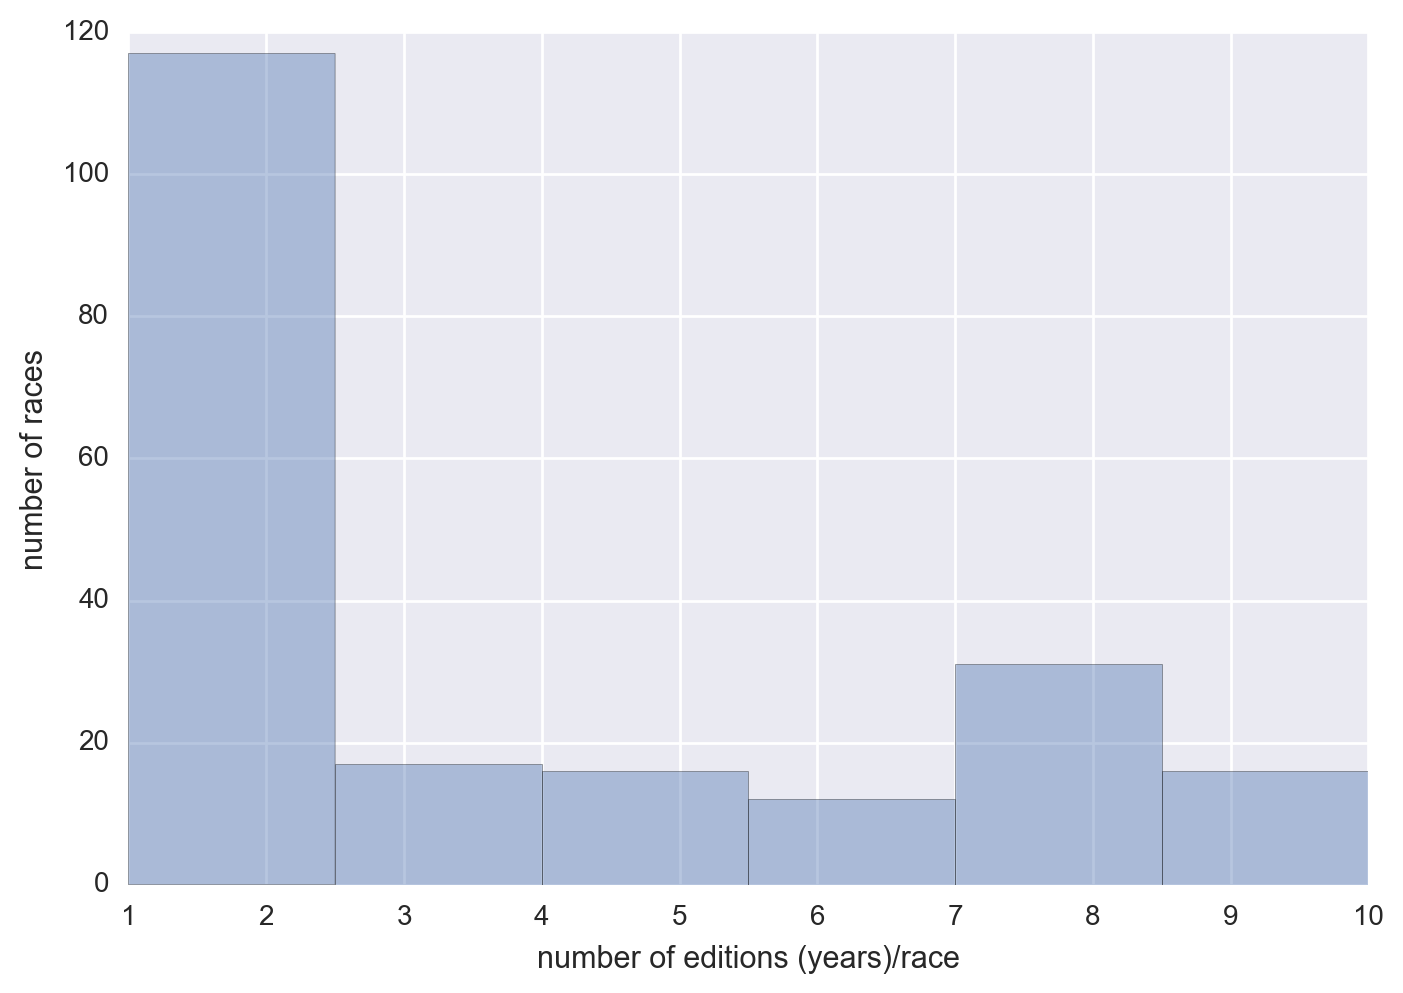

In [56]:
sns.distplot(sorted(editions_counts.values()),kde=False)
plt.xlabel('number of editions (years)/race')
plt.ylabel('number of races');

### Distribution of #runners, per race  
(how popular is a race?)

In [20]:
print('number of unique races:',full_df.Race.nunique())

number of unique races: 209


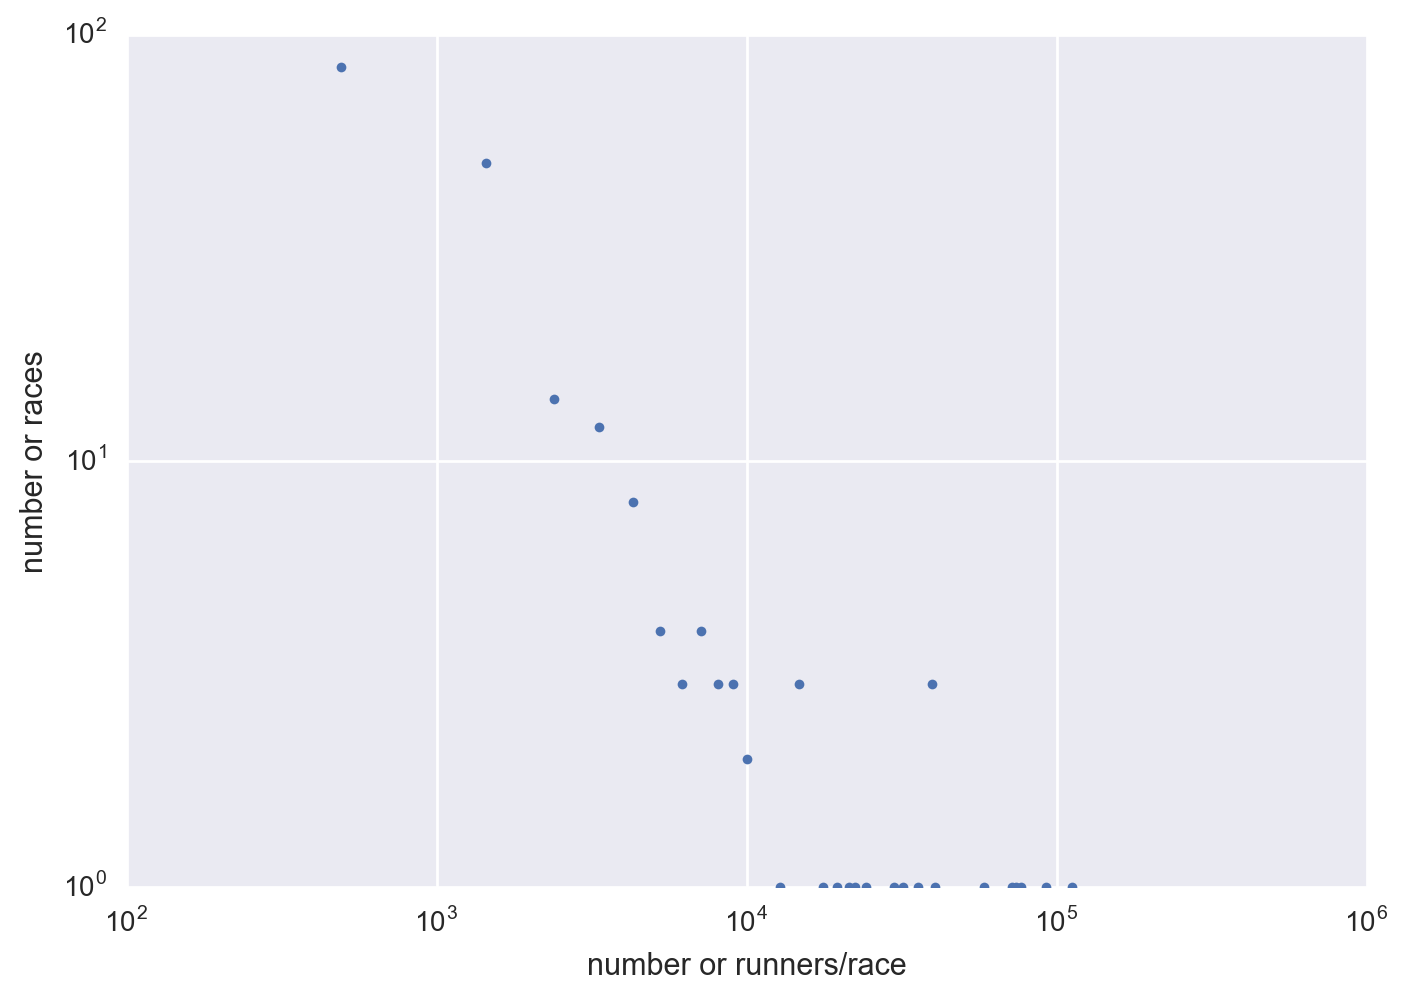

In [19]:
my_hist, bin_edges = np.histogram(full_df.Race.value_counts(),bins='fd')
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2

plt.loglog(bin_centers,my_hist,marker='.',linestyle='')

plt.ylabel('number or races')
plt.xlabel('number or runners/race');

### Distribution of #races, per runner
(how active is a runner?)

In [15]:
print('number of unique runners:',full_df.Name.nunique())

number of unique runners: 424528


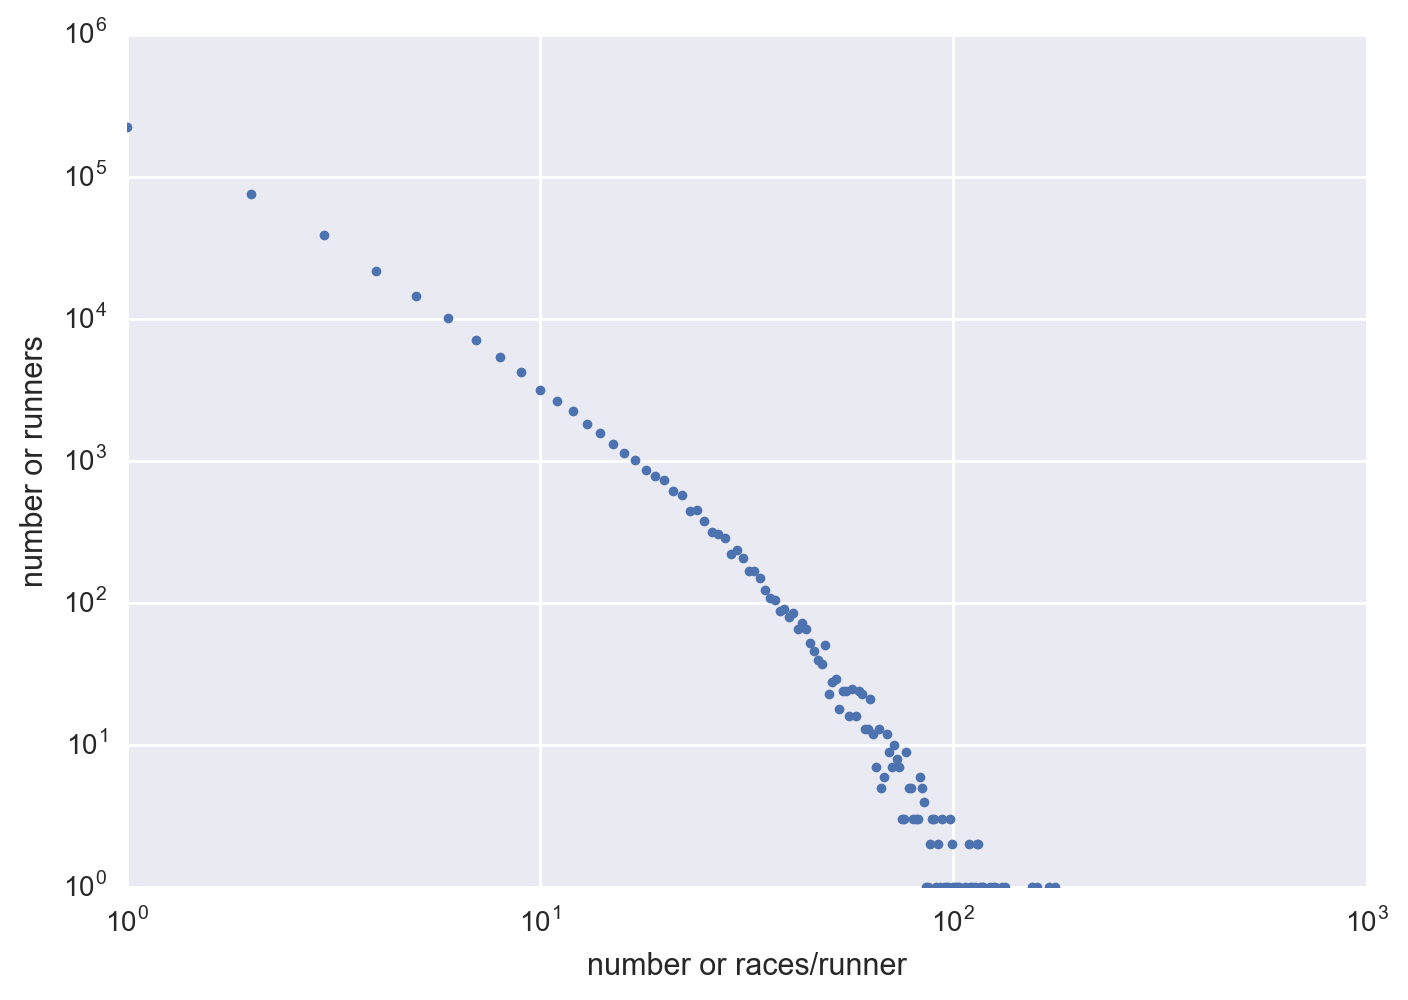

In [18]:
plt.loglog(full_df.Name.value_counts().value_counts(),marker='.',linestyle='')

plt.ylabel('number or runners')
plt.xlabel('number or races/runner');

### Performance VS Age  

This question has been already investigated in recent studies, on different races across the world. Here are few examples, from 
[2014(1)](http://bmcsportsscimedrehabil.biomedcentral.com/articles/10.1186/2052-1847-6-31),
[2014(2)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4039284/),
[2015](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4541133/),
[2016](http://www.sciencedirect.com/science/article/pii/S2095254615000435).

All of them found a _U-shaped dependence_, for both males and females

Let's consider for simplicity the largest races:

In [21]:
runners_count = full_df.Race.value_counts().sort_values(ascending=False)
runners_count[:3]

Course de l'Escalade, Genève     112322
20km de Lausanne                  92572
Zürcher Silvesterlauf, Zürich     77042
Name: Race, dtype: int64

In [33]:
full_df[full_df.Race=='Course de l\'Escalade, Genève'].Distance.unique()

array([ 18.,   2.,   7.,   5.,  17.])

Mind that each race might have _several distances_:

### Performance VS Weather

One of the main study on this topic, from 
[2007](http://journals.lww.com/acsm-msse/pages/articleviewer.aspx?year=2007&issue=03000&article=00012&type=abstract), found correlation between 
[WBGT](https://en.wikipedia.org/wiki/Wet-bulb_globe_temperature)
and decrease of performance, both for male and female runners.  
(An older study from 
[1997](http://journals.lww.com/acsm-msse/pages/articleviewer.aspx?year=1997&issue=09000&article=00018&type=abstract)
found similar negative effects of ambient temperature on resistance in cyclists)

#### exploring features

In [ ]:
# sns.jointplot(full_df.MinTemp,full_df.MaxTemp,kind='kde');

## ML-driven analysis

### Prediction of athletes' career progression

This article on 
[fivethirtyeight](http://fivethirtyeight.com/features/tell-us-two-things-and-well-tell-you-how-fast-youd-run-a-marathon/) 
summarises the results of a recent 
[study](https://bmcsportsscimedrehabil.biomedcentral.com/articles/10.1186/s13102-016-0052-y).
The authors improved a long-standing prective model from 
[1981](http://www.runscore.com/coursemeasurement/Articles/ARHE.pdf),
that estimates the performance (min) of an athlete on the next race, based the distance and performance on the previous one.

In [2]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV